<h1>Cross Shore Acceleration Distribution Test Function</h1>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
%matplotlib widget

In [47]:
# Get Mission 21 netCDF file
# Mission 1 netCDF path
mission_nc_path = '../microSWIFT_data/mission_21/mission_21.nc'

# Load in netCDF file as a dataset
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Define minimum cross shore locations 
min_x = 100 # Minimum Cross Shore location 

# Define Maximum cross shore location based on furthest offshore deployed 
microSWIFTs_on_mission = list(mission_dataset.groups.keys())

# Sort maximum x location
initial_values_set = False
while initial_values_set == False:
    for microSWIFT in microSWIFTs_on_mission:
        if 'GPS' in list(mission_dataset[microSWIFT].groups.keys()):
            if 'x_frf' in list(mission_dataset[microSWIFT]['GPS'].variables):
                # Set initial time labels
                max_x = np.max(mission_dataset[microSWIFT]['GPS']['x_frf'])
                initial_values_set = True
            else:
                continue
        else:
            continue

# Compute maximum x location
for microSWIFT in microSWIFTs_on_mission:
    if 'GPS' in list(mission_dataset[microSWIFT].groups.keys()):
        if 'x_frf' in list(mission_dataset[microSWIFT]['GPS'].variables):
            if np.max(mission_dataset[microSWIFT]['GPS']['x_frf']) > max_x:
                max_x = np.max(mission_dataset[microSWIFT]['GPS']['x_frf'])
            else:
                continue

# Create Cross Shore bin array
bin_width = 10 # Width of cross shore bins, units are meters
num_bin_edges = int((max_x - min_x)/ bin_width)
num_bins = num_bin_edges - 1
cross_shore_bin_edges = np.linspace(min_x, max_x, num_bin_edges)
cross_shore_bin_center = np.linspace(min_x+(bin_width/2), max_x-(bin_width/2), num_bins)

In [30]:
# Define microSWIFTs in mission
microSWIFTs_on_mission = list(mission_dataset.groups.keys())

# Find Accel Values in cross shore bins 
x = mission_dataset['microSWIFT_2']['GPS']['x_frf']
accel_z = mission_dataset['microSWIFT_2']['IMU']['accel_z']
accel_time = nc.num2date(mission_dataset['microSWIFT_2']['IMU']['time'], units=mission_dataset[microSWIFT]['IMU']['time'].units, calendar=mission_dataset[microSWIFT]['IMU']['time'].calendar)

# Define list for accelerations
cross_shore_accel_z = [ [] for _ in range(num_bins) ]

# For each microSWIFT in the mission
for microSWIFT in microSWIFTs_on_mission:
    # Check if the microSWIFT has both GPS and IMU data
    if 'GPS' in list(mission_dataset[microSWIFT].groups.keys()) and 'IMU' in list(mission_dataset[microSWIFT].groups.keys()):
        try:
            cross_shore_loc = mission_dataset[microSWIFT]['GPS']['x_frf'][:]
            gps_time = mission_dataset[microSWIFT]['GPS']['time'][:]
            accel_z = mission_dataset[microSWIFT]['IMU']['accel_z'][:]
            accel_time = nc.num2date(mission_dataset[microSWIFT]['IMU']['time'], units=mission_dataset[microSWIFT]['IMU']['time'].units, calendar=mission_dataset[microSWIFT]['IMU']['time'].calendar)
        except:
            continue
        else:
            # Sort through each bin to find when the microSWIFT is in each cross shore bin
            for n in np.arange(num_bins):
                # Find indices of cross shore values when inside bins
                ind_in_bin = np.argwhere((cross_shore_loc > cross_shore_bin_edges[n]) & (cross_shore_loc < cross_shore_bin_edges[n+1])).squeeze()
                # Find corresponding GPS times when in each bin
                time_in_bin = gps_time[ind_in_bin]
                if time_in_bin.size > 0:
                    # Find min and max times of each bin and convert to a real datetime
                    time_in_bin_min = nc.num2date(np.min(time_in_bin), units=mission_dataset[microSWIFT]['GPS']['time'].units, calendar=mission_dataset[microSWIFT]['GPS']['time'].calendar)
                    time_in_bin_max = nc.num2date(np.max(time_in_bin), units=mission_dataset[microSWIFT]['GPS']['time'].units, calendar=mission_dataset[microSWIFT]['GPS']['time'].calendar)
                    
                    # Find indices of accelerations between these time values
                    ind_accel_in_bin = np.argwhere((accel_time > time_in_bin_min) & (accel_time < time_in_bin_max)).squeeze()
                    # Get Values of Accelerations from time indices
                    mag_accel_z_in_bin = list(np.abs(accel_z[ind_accel_in_bin]))
                    # Append Accelerations to cross shore accelerations list in bin
                    cross_shore_accel_z[n].append(mag_accel_z_in_bin)
                else:
                    continue
    else:
        continue


In [43]:
cross_shore_binned_accel_z = [ [] for _ in range(num_bins) ]

# Flatten the each binned list into one list of accelerations for each bin 
for n in np.arange(num_bins):
    cross_shore_binned_accel_z[n] = sum(cross_shore_accel_z[n], []) 

# Make a 2D Histogram of the cross shore binned accelerations
num_accel_bins = 100
min_accel_z = np.min(np.min(cross_shore_binned_accel_z))
max_accel_z = np.max(np.max(cross_shore_binned_accel_z))
accel_bin_edges = np.linspace(min_accel_z, max_accel_z, num_accel_bins+1)
cross_shore_accel_z_hist = np.zeros((num_accel_bins, num_bins))
for n in np.arange(num_bins):
    cross_shore_accel_z_hist[:,n], accel_bin_edges = np.histogram(cross_shore_binned_accel_z[n], bins=accel_bin_edges, density=True)


/Volumes/DUNEXdata/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [54]:
# Compute Mean and Standard Deviation of each cross shore location distribution 
cross_shore_means = np.empty(num_bins)
cross_shore_upper_std = np.empty(num_bins)
cross_shore_lower_std = np.empty(num_bins)

for n in np.arange(num_bins):
    cross_shore_means[n] = np.mean(cross_shore_binned_accel_z[n])
    dist_std = np.std(cross_shore_binned_accel_z[n])
    cross_shore_upper_std[n] = cross_shore_means[n] + dist_std
    cross_shore_lower_std[n] = cross_shore_means[n] - dist_std

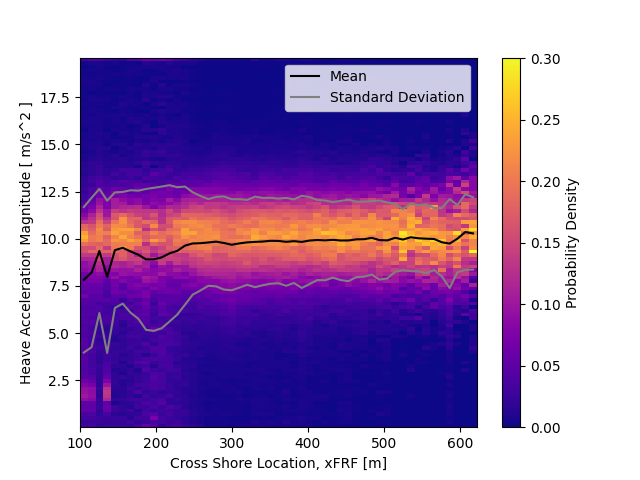

In [60]:
cross_shore_binned_accel_z = [ [] for _ in range(num_bins) ]

# Flatten the each binned list into one list of accelerations for each bin 
for n in np.arange(num_bins):
    cross_shore_binned_accel_z[n] = sum(cross_shore_accel_z[n], []) 

# Make a 2D Histogram of the cross shore binned accelerations
num_accel_bins = 100
min_accel_z = np.min(np.min(cross_shore_binned_accel_z))
max_accel_z = np.max(np.max(cross_shore_binned_accel_z))
accel_bin_edges = np.linspace(min_accel_z, max_accel_z, num_accel_bins+1)
cross_shore_accel_z_hist = np.zeros((num_accel_bins, num_bins))
for n in np.arange(num_bins):
    cross_shore_accel_z_hist[:,n], accel_bin_edges = np.histogram(cross_shore_binned_accel_z[n], bins=accel_bin_edges, density=True)


In [58]:
# Get Mission 21 netCDF file
# Mission 1 netCDF path
mission_nc_path = '../microSWIFT_data/mission_21/mission_21.nc'

# Load in netCDF file as a dataset
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Define minimum cross shore locations 
min_x = 100 # Minimum Cross Shore location 

# Define Maximum cross shore location based on furthest offshore deployed 
microSWIFTs_on_mission = list(mission_dataset.groups.keys())

# Sort maximum x location
initial_values_set = False
while initial_values_set == False:
    for microSWIFT in microSWIFTs_on_mission:
        if 'GPS' in list(mission_dataset[microSWIFT].groups.keys()):
            if 'x_frf' in list(mission_dataset[microSWIFT]['GPS'].variables):
                # Set initial time labels
                max_x = np.max(mission_dataset[microSWIFT]['GPS']['x_frf'])
                initial_values_set = True
            else:
                continue
        else:
            continue

# Compute maximum x location
for microSWIFT in microSWIFTs_on_mission:
    if 'GPS' in list(mission_dataset[microSWIFT].groups.keys()):
        if 'x_frf' in list(mission_dataset[microSWIFT]['GPS'].variables):
            if np.max(mission_dataset[microSWIFT]['GPS']['x_frf']) > max_x:
                max_x = np.max(mission_dataset[microSWIFT]['GPS']['x_frf'])
            else:
                continue

# Create Cross Shore bin array
bin_width = 10 # Width of cross shore bins, units are meters
num_bin_edges = int((max_x - min_x)/ bin_width)
num_bins = num_bin_edges - 1
cross_shore_bin_edges = np.linspace(min_x, max_x, num_bin_edges)
cross_shore_bin_center = np.linspace(min_x+(bin_width/2), max_x-(bin_width/2), num_bins)

# Find Accel Values in cross shore bins 
x = mission_dataset['microSWIFT_2']['GPS']['x_frf']
accel_z = mission_dataset['microSWIFT_2']['IMU']['accel_z']
accel_time = nc.num2date(mission_dataset['microSWIFT_2']['IMU']['time'], units=mission_dataset[microSWIFT]['IMU']['time'].units, calendar=mission_dataset[microSWIFT]['IMU']['time'].calendar)

# Define list for accelerations
cross_shore_accel_z = [ [] for _ in range(num_bins) ]

# For each microSWIFT in the mission
for microSWIFT in microSWIFTs_on_mission:
    # Check if the microSWIFT has both GPS and IMU data
    if 'GPS' in list(mission_dataset[microSWIFT].groups.keys()) and 'IMU' in list(mission_dataset[microSWIFT].groups.keys()):
        try:
            cross_shore_loc = mission_dataset[microSWIFT]['GPS']['x_frf'][:]
            gps_time = mission_dataset[microSWIFT]['GPS']['time'][:]
            accel_z = mission_dataset[microSWIFT]['IMU']['accel_z'][:]
            accel_time = nc.num2date(mission_dataset[microSWIFT]['IMU']['time'], units=mission_dataset[microSWIFT]['IMU']['time'].units, calendar=mission_dataset[microSWIFT]['IMU']['time'].calendar)
        except:
            continue
        else:
            # Sort through each bin to find when the microSWIFT is in each cross shore bin
            for n in np.arange(num_bins):
                # Find indices of cross shore values when inside bins
                ind_in_bin = np.argwhere((cross_shore_loc > cross_shore_bin_edges[n]) & (cross_shore_loc < cross_shore_bin_edges[n+1])).squeeze()
                # Find corresponding GPS times when in each bin
                time_in_bin = gps_time[ind_in_bin]
                if time_in_bin.size > 0:
                    # Find min and max times of each bin and convert to a real datetime
                    time_in_bin_min = nc.num2date(np.min(time_in_bin), units=mission_dataset[microSWIFT]['GPS']['time'].units, calendar=mission_dataset[microSWIFT]['GPS']['time'].calendar)
                    time_in_bin_max = nc.num2date(np.max(time_in_bin), units=mission_dataset[microSWIFT]['GPS']['time'].units, calendar=mission_dataset[microSWIFT]['GPS']['time'].calendar)
                    
                    # Find indices of accelerations between these time values
                    ind_accel_in_bin = np.argwhere((accel_time > time_in_bin_min) & (accel_time < time_in_bin_max)).squeeze()
                    # Get Values of Accelerations from time indices
                    mag_accel_z_in_bin = list(np.abs(accel_z[ind_accel_in_bin]))
                    # Append Accelerations to cross shore accelerations list in bin
                    cross_shore_accel_z[n].append(mag_accel_z_in_bin)
                else:
                    continue
    else:
        continue

# Make list for binned accels
cross_shore_binned_accel_z = [ [] for _ in range(num_bins) ]

# Flatten the each binned list into one list of accelerations for each bin 
for n in np.arange(num_bins):
    cross_shore_binned_accel_z[n] = sum(cross_shore_accel_z[n], []) 

# Make a 2D Histogram of the cross shore binned accelerations
num_accel_bins = 100
min_accel_z = np.min(np.min(cross_shore_binned_accel_z))
max_accel_z = np.max(np.max(cross_shore_binned_accel_z))
accel_bin_edges = np.linspace(min_accel_z, max_accel_z, num_accel_bins+1)
cross_shore_accel_z_hist = np.zeros((num_accel_bins, num_bins))
for n in np.arange(num_bins):
    cross_shore_accel_z_hist[:,n], accel_bin_edges = np.histogram(cross_shore_binned_accel_z[n], bins=accel_bin_edges, density=True)

# Compute Mean and Standard Deviation of each cross shore location distribution 
cross_shore_means = np.empty(num_bins)
cross_shore_upper_std = np.empty(num_bins)
cross_shore_lower_std = np.empty(num_bins)

for n in np.arange(num_bins):
    cross_shore_means[n] = np.mean(cross_shore_binned_accel_z[n])
    dist_std = np.std(cross_shore_binned_accel_z[n])
    cross_shore_upper_std[n] = cross_shore_means[n] + dist_std
    cross_shore_lower_std[n] = cross_shore_means[n] - dist_std

# Make grids of the bin edges to plot
accel_bin_grid, cross_shore_bin_grid = np.meshgrid(accel_bin_edges, cross_shore_bin_edges)

# Plot the cross shore binned histograms of accelerations
fig_cross_dist, ax = plt.subplots()
hist_plot = ax.pcolormesh(cross_shore_bin_edges, accel_bin_edges, cross_shore_accel_z_hist, cmap='plasma')
ax.plot(cross_shore_bin_center, cross_shore_means, color='k')
ax.plot(cross_shore_bin_center, cross_shore_upper_std, color='gray')
ax.plot(cross_shore_bin_center, cross_shore_lower_std, color='gray')
cbar = fig_cross_dist.colorbar(hist_plot, ax=ax)
cbar.set_label('Probability Density')
ax.set_xlabel('Cross Shore Location, xFRF [m]')
ax.set_ylabel('Heave Acceleration Magnitude [ m/s^2 ]')
ax.legend(['Mean', 'Standard Deviation'])

Signature: ax.legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(labels)
    legend(handles, labels)

The call signatures correspond to these three different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `.Axes.legend` without
any arguments and without setting the labels manually will result